In [1]:
# Import Denpendencies
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.linalg as spl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import time
import h5py
from tl_utils import *

In [2]:
class KLDNN(nn.Module):
    
    def __init__(self, layer_nn, 
                     Nt, Nx, xiK_r, dt, dx,
                     meanK, PhiK, meanU, PhiU, 
                     dtype, device):
        
        super(KLDNN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        for i in range(len(layer_nn) - 1):
            self.layers.append(nn.Linear(layer_nn[i], layer_nn[i+1], dtype = dtype, device = device))

        self.Nt = Nt
        self.Nx = Nx
        self.xiK_r = xiK_r
        self.dt = dt
        self.dx = dx
        self.NKxi = layer_nn[0]
        self.Nuxi = layer_nn[-1]
        self.dtype = dtype
        self.device = device
        
        self.meanK = torch.tensor(meanK.copy(), dtype = self.dtype).to(self.device)
        self.PhiK = torch.tensor(PhiK.copy(), dtype = self.dtype).to(self.device)
        self.PhiU = torch.tensor(PhiU.copy(), dtype = self.dtype).to(self.device)
        self.meanU = torch.tensor(meanU.copy(), dtype = self.dtype).to(self.device)
        
        self.PhiU_rs = self.PhiU.reshape((self.Nt, self.Nx, self.Nuxi))
        self.meanU_rs = self.meanU.reshape((self.Nt, self.Nx))
        
        # the first derivative of u mean w.r.t t
        self.d1tdmeanU = torch.zeros((self.Nt, self.Nx), dtype = self.dtype, device = self.device)
        self.d1tdmeanU[1:, 1:-1] = (self.meanU_rs[1:, 1:-1] - self.meanU_rs[:-1, 1:-1]) / self.dt
        # the first derivative of u eigenfunctions w.r.t t
        self.d1tdPhiU = torch.zeros((self.Nt, self.Nx, self.Nuxi), dtype = self.dtype, device = self.device)
        self.d1tdPhiU[1:, 1:-1, :] = (self.PhiU_rs[1:, 1:-1, :] - self.PhiU_rs[:-1, 1:-1, :]) / self.dt
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:  
                x = nn.functional.relu(x)
        return x
    
    def d2xdmeanUK(self, xiK_batch):
        
        Nbatch = xiK_batch.shape[0]
        K = torch.einsum('ij,nj->ni', self.PhiK, xiK_batch) + self.meanK  # (Nbatch, self.Nx-1) 
        K_eff = (2 * K[:, :-1] * K[:, 1:] / (K[:, :-1] + K[:, 1:])).reshape(Nbatch, 1, self.Nx - 1)
        d2xdmeanUK_ = torch.zeros((Nbatch, self.Nt, self.Nx), dtype = self.dtype).to(self.device)
        d2xdmeanUK_[:, 1:, 1:-1] = (K_eff[:, :, 1:] * (self.meanU_rs[None, 1:, 2:] - self.meanU_rs[None, 1:, 1:-1]) -
                                    K_eff[:, :, :-1] * (self.meanU_rs[None, 1:, 1:-1] - self.meanU_rs[None, 1:, :-2])) / self.dx**2
        
        return d2xdmeanUK_
    
    def d2xdPhiUK(self, xiK_batch):
        
        Nbatch = xiK_batch.shape[0]
        K = torch.einsum('ij,nj->ni', self.PhiK, xiK_batch) + self.meanK  
        K_eff = (2 * K[:, :-1] * K[:, 1:] / (K[:, :-1] + K[:, 1:])).reshape(Nbatch, 1, self.Nx - 1, 1)
        d2xdPhiUK_ = torch.zeros((Nbatch, self.Nt, self.Nx, self.Nuxi), dtype = self.dtype).to(self.device)
        d2xdPhiUK_[:, 1:, 1:-1, :] = (K_eff[:, :, 1:, :] * (self.PhiU_rs[None, 1:, 2:, :] - self.PhiU_rs[None, 1:, 1:-1, :]) -
                                      K_eff[:, :, :-1, :] * (self.PhiU_rs[None, 1:, 1:-1, :] - self.PhiU_rs[None, 1:, :-2, :])) / self.dx**2
        return d2xdPhiUK_
    
    def residual(self, xiK_batch, xiU_batch):
        
        A = self.d1tdPhiU - self.d2xdPhiUK(xiK_batch) # (batch, Nt, Nx, Nuxi)
        b = self.d1tdmeanU - self.d2xdmeanUK(xiK_batch) # (batch, Nt, Nx)
        return torch.einsum('nijk,nk->nij', A, xiU_batch) + b # (batch, Nt, Nx)
    
    def residual_loss(self, xiK):
        
        xiU_pred = self.forward(xiK)
        residual = self.residual(xiK, xiU_pred)
        loss = torch.mean(torch.norm(residual, dim = (1,2)))
        return loss
        
    def train_model(self, input_train, output_train, 
                    input_test, output_test, 
                    lambda_r, optim, batch_size, num_print, num_epoch, plot_loss = True):
        
        # lambda_r for enforce physics constraints
        loss_train = []
        data_loss_train = []
        res_loss_train = []
        loss_test = []
        train_dataset = TensorDataset(input_train, output_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
        
        since = time.time()
        if lambda_r == 0:
            for epoch in range(num_epoch):
                for input_batch, output_batch in train_loader:
                    self.train()
                    optim.zero_grad()
                    output_batch_pred = self.forward(input_batch)
                    loss = nn.MSELoss()(output_batch_pred, output_batch)
                    loss.backward()
                    optim.step()
                loss_train.append(loss.detach().cpu().numpy())
                
                if epoch%num_print == 0:
                    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
                
                with torch.inference_mode():
                    self.eval()
                    output_test_pred = self.forward(input_test)
                    test_loss = nn.MSELoss()(output_test_pred, output_test)
                loss_test.append(test_loss.detach().cpu().numpy())
                
        else:
            for epoch in range(num_epoch):
                for input_batch, output_batch in train_loader:
                    self.train()
                    optim.zero_grad()
                    output_batch_pred = self.forward(input_batch)
                    data_loss_train_ = nn.MSELoss()(output_batch_pred, output_batch)
                    res_loss_train_ = self.residual_loss(self.xiK_r)
                    #loss_train_ = data_loss_train_ + lambda_r*res_loss_train_
                    loss_train_ = res_loss_train_
                    loss_train_.backward()
                    optim.step()
                loss_train.append(loss_train_.detach().cpu().numpy())
                data_loss_train.append(data_loss_train_.detach().cpu().numpy())
                res_loss_train.append((lambda_r*res_loss_train_).detach().cpu().numpy())
                
                if epoch%num_print == 0:
                    print(f'Epoch: {epoch:03d}, Loss:{loss_train_:.3f}, Data:{data_loss_train_:.3f}, Physics:{lambda_r*res_loss_train_:.3f}')
                
                with torch.inference_mode():
                    self.eval()
                    output_test_pred = self.forward(input_test)
                    data_loss_test = nn.MSELoss()(output_test_pred, output_test)
                    res_loss_test = self.residual_loss(self.xiK_r)
                    #loss_test_ = data_loss_test + lambda_r*res_loss_test
                    loss_test_ = res_loss_test
                loss_test.append(loss_test_.detach().cpu().numpy())
            
        time_elapsed = time.time() - since
        print(f'Training time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        
        if plot_loss == True:
            plt.figure(figsize=(4,4), dpi = 300)
            plt.title(f'epoch={num_epoch},batch={batch_size}')
            plt.plot(np.arange(num_epoch), loss_train, label = 'Train loss')
            plt.plot(np.arange(num_epoch), loss_test, label = 'Test loss')
            if lambda_r != 0:
                plt.plot(np.arange(num_epoch), data_loss_train, label = 'Data loss')
                plt.plot(np.arange(num_epoch), res_loss_train, label = 'Residual loss')
            plt.xlabel('Number of epochs')
            plt.ylabel('Loss')
            plt.legend(loc='best')
            plt.show()
        
        return loss_train, loss_test


# Problem Setup for the non-linear problem
For linear PDE problems, the moment equations for $\overline{h}$, $h'$, and $C_h$ are decoupled. However, the moment equations are coupled for nonlinear PDE problems, which might affect the transferability of the parameters in the KL-NN model. Here, we consider the one-dimensional diffusion equation with the space-dependent control variable $k(x)$:

$$
\frac{\partial h}{\partial t} = \frac{\partial}{\partial x} \left[ k(x) \frac{\partial h}{\partial x} \right], \quad x \in [0, L], \quad t \in [0, T],
$$

subject to the initial condition:

$$
h(x, t=0) = h_0, \quad x \in [0, L],
$$

and the boundary conditions:

$$
h(x=0, t) = h_l, \quad h(x=L, t) = h_r, \quad t \in [0, T].
$$

This equation, among other applications, describes the flow in a confined aquifer with a heterogeneous conductivity field. We model the control variable $k(x)$ with the KLD:

$$
k(x) \approx \mathcal{KL} \left[\overline{k}, \bm\psi_k, \bm\xi_k \right],
$$

and the surrogate model takes the form:

$$
\hat{h}(x, t | k; \bm{\theta}) = \mathcal{KL} \left[\overline{h}, \bm\psi_h, \mathcal{NN}(\bm\xi_k; \bm\theta) \right].
$$

To simplify the analysis, we further assume that the initial condition $h_0$ and boundary conditions $h_l$ and $h_r$ are <span style="color:blue"> deterministic <span> and <span style="color:blue"> different <span> for the source and target problems.


In [4]:
# =============================================================================
# Model setup
# =============================================================================
seed = 15
rng = np.random.default_rng(seed)
L = 1.0 # Domain length
Disp = 10

# Source Dirichlet BC at x=0 and x=L
ul_s = 1 + 0.05 * L
ur_s = 1 - 0.05 * L
u0_s = ul_s # initial condition

# Target Dirichlet BC at x=0 and x=L
ul_t = ul_s - 0.1 * L
ur_t = ur_s + 0.1 * L
u0_t = ul_t # initial condition

load_data = True
Nmc_s = 1000
Nmc_t = 7 #7, 13, 25, 100
Nx = 30  # Number of grid points in space
Nt = 250  # Number of grid points in time
dx = L / (Nx - 1)  # Grid size
dt = dx**2 / Disp  # Time step satisfying Courant condition
T = dt * (Nt - 1)  # Time length
tr = np.linspace(0, T, Nt)
xr = np.linspace(0, L, Nx)
XX, TT = np.meshgrid(xr, tr)
Nr = Nx * Nt  # Number of residual points in space-time
NYxi = 20  # Number of KL terms in the Y=lnK expansions
NKxi = 20  # Number of KL terms in the K expansions
Nuxi = 40  # Number of KL terms in the u expansions

In [5]:
# Reference gaussian Y field and K field
gammaY, varY = 0.5, 0.3
CovY = varY * np.exp(- (xr[:, np.newaxis] - xr)**2 / gammaY**2)
PhiY, LambdaY = get_eigenpairs(CovY)  
#cumY = np.cumsum(LambdaY)/np.sum(LambdaY)

xiY_s = rng.standard_normal((Nmc_s, NYxi))  
Kmc_s = Disp * np.exp(np.einsum('ij,kj->ki', PhiY[:, :NYxi], xiY_s)) # Ensemble of K data
meanK = np.mean(Kmc_s, axis = 0)
covK = np.cov(Kmc_s.T) 
PhiK, LambdaK = get_eigenpairs(covK)

# "Effective" K   
xiY_ref = rng.standard_normal(NYxi) 
K_ref = Disp * np.exp(PhiY[:, :NYxi] @ xiY_ref)
K_eff = np.zeros(Nx - 1)
for i in range(Nx - 1): # Effective conductivity
    K_eff[i] = 2 * K_ref[i] * K_ref[i + 1] / (K_ref[i] + K_ref[i + 1])
xiK_ref = np.linalg.lstsq(PhiK[:,:NKxi], (K_ref - meanK).T, rcond=-1)[0].T # LS fitting

meanK_eff = np.zeros(Nx - 1)  
PhiK_eff = np.zeros((Nx - 1, NKxi))
for i in range(Nx - 1):
    meanK_eff[i] = 2 * meanK[i] * meanK[i + 1] / (meanK[i] + meanK[i + 1])
    for j in range(NKxi):
        PhiK_eff[i, j] = 2 * PhiK[i, j] * PhiK[i + 1, j] / (PhiK[i, j] + PhiK[i + 1, j])

In [6]:
if load_data == True:
    with h5py.File(f'./tl_kldnn_multiplicative_varY_{varY}_seed_{seed}.h5', 'r') as f:
        #print([key for key in f.keys()])    
        umc_s = f.get('u_source')[:] 
else:
    umc_s = np.zeros((Nmc_s, Nt * Nx))  # Ensemble of u data
    for i in range(Nmc_s):
        usol = darcy_solver_implicit(Kmc_s[i, :], Nt, Nx, ul_s, ur_s, u0_s, dt, dx)
        umc_s[i, :] = usol.reshape(-1)
    with h5py.File(f'./tl_kldnn_multiplicative_varY_{varY}_seed_{seed}.h5', 'w') as f:
        f.create_dataset('u_source', data = umc_s)
        
meanU_s = np.mean(umc_s, axis = 0)
covU = np.cov(umc_s.T) 
PhiU, LambdaU = get_eigenpairs(covU)
PhiU_rs = PhiU[:,:Nuxi].reshape((Nt, Nx, Nuxi))
meanU_rs = meanU_s.reshape((Nt, Nx))

rng2 = np.random.default_rng(6)
umc_t = np.zeros((Nmc_t, Nt*Nx))
Kmc_t = np.zeros((Nmc_t, Nx))  
for i in range(Nmc_t):
    xiY_t = rng2.standard_normal(NYxi)  
    K_t = Disp * np.exp(np.einsum('ij,j->i', PhiY[:, :NYxi], xiY_t))
    u_t = darcy_solver_implicit(K_t, Nt, Nx, ul_t, ur_t, u0_t, dt, dx)
    Kmc_t[i, :] = K_t
    umc_t[i, :] = u_t.ravel()

# The reference data
u_ref_s = darcy_solver_implicit(K_ref, Nt, Nx, ul_s, ur_s, u0_s, dt, dx)
u_ref_t = darcy_solver_implicit(K_ref, Nt, Nx, ul_t, ur_t, u0_t, dt, dx)
meanU_t = darcy_solver_implicit(meanK, Nt, Nx, ul_t, ur_t, u0_t, dt, dx).reshape(-1)
xiU_ref_s = np.linalg.lstsq(PhiU[:,:Nuxi], (u_ref_s.ravel() - meanU_s).T, rcond=-1)[0].T # LS fitting

In [7]:
# =============================================================================
# KL-DNN model
# =============================================================================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
torch_seed = 42
torch.manual_seed(torch_seed)
input_dim = NKxi
output_dim = Nuxi
hidden_size = 50
layers_nn = [input_dim, hidden_size, hidden_size, output_dim]
batch_size = 50
lr = 1e-3
num_print = 200
num_epoch_s = 4000
num_epoch_t = 4000
lambda_r_s = 0 # no physcis constraint for source training
lambda_r_t = 1e-4
Nres = 250

In [8]:
# ===================== Data Preparation =================================

xiK_r = torch.normal(0, 1, size=(Nres, NKxi), dtype = dtype).to(device)

Ns_train = int(Nmc_s*0.8)
Ns_test = Nmc_s - Ns_train

xiU_s = np.linalg.lstsq(PhiU[:,:Nuxi], (umc_s - meanU_s).T, rcond=-1)[0].T # (Nmc_s, Nuxi)
xiK_s = np.linalg.lstsq(PhiK[:,:NKxi], (Kmc_s - meanK).T, rcond=-1)[0].T # (Nmc_s, NKxi)
xiU_s_train = torch.tensor(xiU_s[:Ns_train, :], dtype=dtype).to(device)
xiK_s_train = torch.tensor(xiK_s[:Ns_train, :], dtype=dtype).to(device)
xiU_s_test = torch.tensor(xiU_s[Ns_train:, :], dtype=dtype).to(device)
xiK_s_test = torch.tensor(xiK_s[Ns_train:, :], dtype=dtype).to(device)
xiK_ref_torch = torch.tensor(xiK_ref[np.newaxis, :], dtype=dtype).to(device)

Layer: layers.0.weight | Size: torch.Size([50, 20]) | Requires Grad: True
Layer: layers.0.bias | Size: torch.Size([50]) | Requires Grad: True
Layer: layers.1.weight | Size: torch.Size([50, 50]) | Requires Grad: True
Layer: layers.1.bias | Size: torch.Size([50]) | Requires Grad: True
Layer: layers.2.weight | Size: torch.Size([40, 50]) | Requires Grad: True
Layer: layers.2.bias | Size: torch.Size([40]) | Requires Grad: True
Epoch: 000, Loss: 0.6328
Epoch: 200, Loss: 0.3275
Epoch: 400, Loss: 0.1401
Epoch: 600, Loss: 0.1256
Epoch: 800, Loss: 0.1101
Epoch: 1000, Loss: 0.0975
Epoch: 1200, Loss: 0.0824
Epoch: 1400, Loss: 0.0715
Epoch: 1600, Loss: 0.0955
Epoch: 1800, Loss: 0.1058
Epoch: 2000, Loss: 0.0827
Epoch: 2200, Loss: 0.0805
Epoch: 2400, Loss: 0.0629
Epoch: 2600, Loss: 0.0804
Epoch: 2800, Loss: 0.0631
Epoch: 3000, Loss: 0.0673
Epoch: 3200, Loss: 0.0632
Epoch: 3400, Loss: 0.0588
Epoch: 3600, Loss: 0.0761
Epoch: 3800, Loss: 0.0635
Training time: 1m 8s


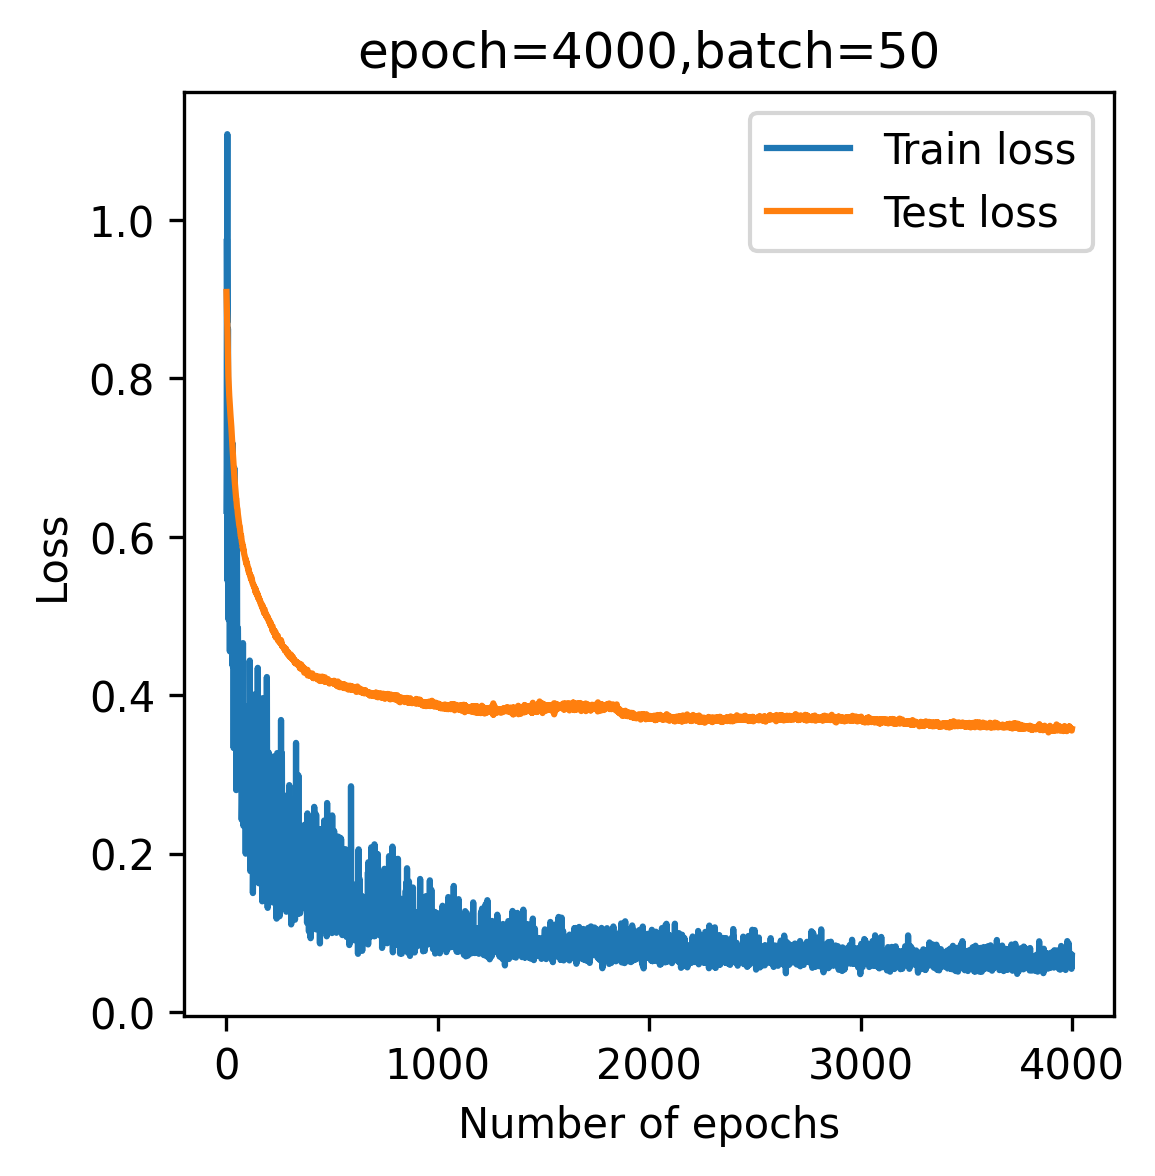

KL-DNN method for the source condition
RL2 error between u pred and u ref for source: 4.811e-04


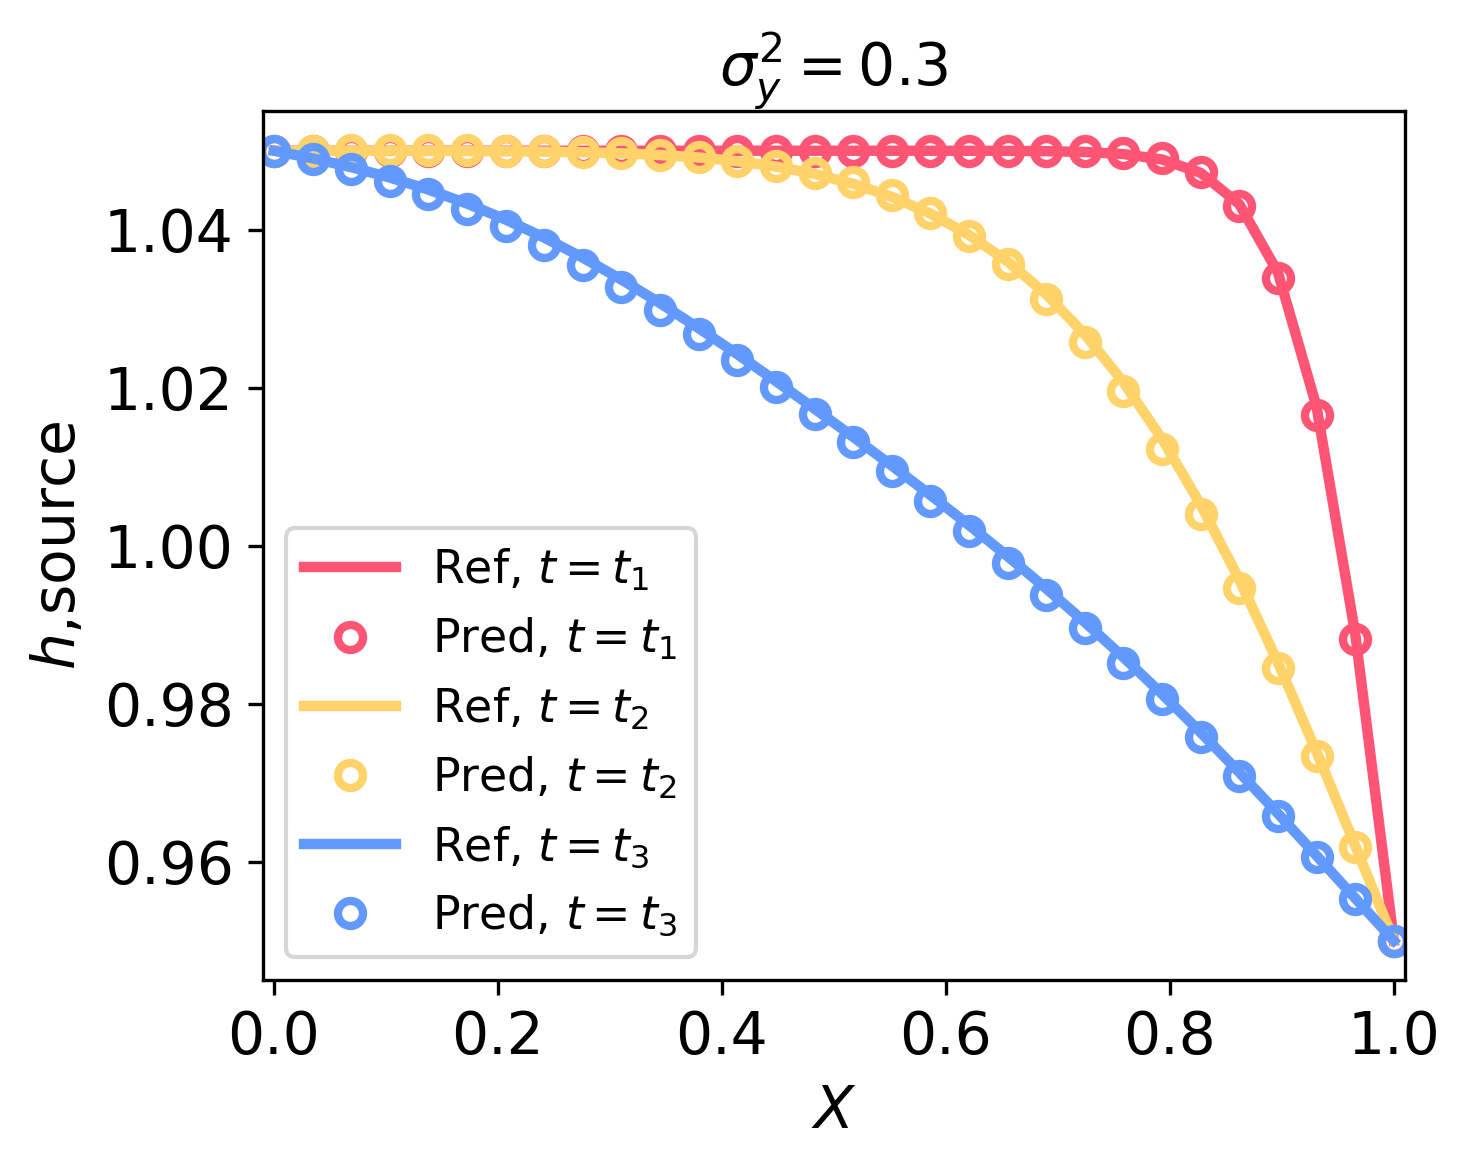

(<Figure size 1500x1200 with 1 Axes>,
 <Axes: title={'center': '$\\sigma^2_y = 0.3$'}, xlabel='$X$', ylabel='$h$,source'>)

In [9]:
# ===================== Source model training =================================

model_s = KLDNN(layers_nn, 
              Nt, Nx, xiK_r, dt, dx,
              meanK, PhiK[:, :NKxi], meanU_s, PhiU[:, :Nuxi], 
              dtype, device).to(device)
for name, param in model_s.named_parameters(): 
    print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")
optim_s = torch.optim.Adam(model_s.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim_s, step_size= 100, gamma= 0.5)
loss_train, loss_test = model_s.train_model(xiK_s_train, xiU_s_train, 
                                            xiK_s_test, xiU_s_test, 
                                            lambda_r_s,
                                            optim_s, batch_size, num_print, num_epoch_s)

# Make prediction
with torch.no_grad():
    xiU_ref_pred = model_s(xiK_ref_torch).cpu().numpy()
u_kldnn_s = (meanU_s + PhiU[:, :Nuxi] @ xiU_ref_pred[0, :]).reshape((Nt, Nx))
print('KL-DNN method for the source condition')
print('RL2 error between u pred and u ref for source: {:.3e}'.format(rl2e(u_kldnn_s, u_ref_s)))
plot_sol(xr, u_ref_s, u_kldnn_s, Nt, label = 'source', title = f'$\sigma^2_y = {varY}$')

In [ ]:
#Ensemble DNN training
Nrandom = 20
Nt_train = int(Nmc_t*0.8)
Nt_test = Nmc_t - Nt_train
umc_t = np.zeros((Nmc_t, Nt*Nx))
Kmc_t = np.zeros((Nmc_t, Nx))  
num_epoch = 4000
lr = 1e-3
num_print = 200
rl2e_arr = []
rng_arr = np.concatenate([np.array([42]), np.arange(0, Nrandom)])
ukl_mat = np.zeros((Nrandom + 1, Nt, Nx))

for index, seed in enumerate(rng_arr):
    rng2 = np.random.default_rng(seed)
    for i in range(Nmc_t):
        xiY_t = rng2.standard_normal(NYxi)  
        K_t = Disp * np.exp(np.einsum('ij,j->i', PhiY[:, :NYxi], xiY_t))
        u_t = darcy_solver_implicit(K_t, Nt, Nx, ul_t, ur_t, u0_t, dt, dx)
        Kmc_t[i, :] = K_t
        umc_t[i, :] = u_t.ravel()
    
    xiU_t = np.linalg.lstsq(PhiU[:,:Nuxi], (umc_t - meanU_t.ravel()).T, rcond=-1)[0].T #(Nmc_t, Nuxi)
    xiK_t = np.linalg.lstsq(PhiK[:,:NKxi], (Kmc_t - meanK).T, rcond=-1)[0].T #(Nmc_t, NKxi)
    xiU_t_train = torch.tensor(xiU_t[:Nt_train, :], dtype=dtype).to(device)
    xiK_t_train = torch.tensor(xiK_t[:Nt_train, :], dtype=dtype).to(device)
    xiU_t_test = torch.tensor(xiU_t[Nt_train:, :], dtype=dtype).to(device)
    xiK_t_test = torch.tensor(xiK_t[Nt_train:, :], dtype=dtype).to(device)

    model_t = KLDNN(layers_nn, 
                  Nt, Nx, xiK_r, dt, dx,
                  meanK, PhiK[:, :NKxi], meanU_t, PhiU[:, :Nuxi], 
                  dtype, device).to(device)
    model_t.load_state_dict(model_s.state_dict(), strict=False)
    
    for param in model_t.parameters():
        param.requires_grad = False  
    for param in model_t.layers[-1].parameters():
        param.requires_grad = True

    optim_t = torch.optim.Adam(model_t.parameters(), lr=lr, weight_decay=1e-4)
    scheduler_t = torch.optim.lr_scheduler.StepLR(optim_t, step_size= 100, gamma= 0.5)
    loss_train, loss_test = model_t.train_model(xiK_t_train, xiU_t_train, 
                                                xiK_t_test, xiU_t_test, 
                                                lambda_r_t,
                                                optim_t, batch_size, num_print, num_epoch_t)  
    with torch.no_grad():
        xiU_ref_pred = model_t(xiK_ref_torch).cpu().numpy()
    u_kldnn_t = (meanU_t + PhiU[:, :Nuxi] @ xiU_ref_pred[0, :]).reshape((Nt, Nx))

    ukl_mat[index, ...] = u_kldnn_t
    rl2e_arr.append(rl2e(u_kldnn_t, u_ref_t))
print('RL2 error between u pred and u ref for source: {:.3e}'.format(np.mean(rl2e_arr)))

index = np.argmin(rl2e_arr)
plot_sol(xr, u_ref_t, ukl_mat[index, ...], Nt, label = 'target', title = f'$\sigma^2_y = {varY}$')